# Hand written digits recognition using neural network built from scratch in numpy
After a while of learning about neural networks I decided to build one from scratch in numpy. I chose to use MNIST dataset as it is a good starting point for beginners. I will use 3 layer neural network with relu activation function and softmax output layer. In between of Python code I'll try to derive the formulas for backpropagation and explain the code for my own understanding.

## Importing libraries
The list will probably grow as I go through the project

In [648]:
import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import math

## Getting THE dataset
This piece of code was shamelessly copied from [Matt Petersen's blog](https://mattpetersen.github.io/load-mnist-with-numpy).
The function looks for the dataset in the specified directory and if it's not there it downloads it from [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). The function returns 4 numpy arrays: training images, training labels, test images and test labels. The images are flattened to 784 pixels (28x28) and the labels are one hot encoded (Whatever that means, will have to figure it out).

In [649]:
def mnist(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing MNIST. Default is
            /home/USER/data/mnist or C:\Users\USER\data\mnist.
            Create if nonexistant. Download any missing files.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'mnist')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))

    return train_images, train_labels, test_images, test_labels

# https://mattpetersen.github.io/load-mnist-with-numpy

In [650]:
x_train, y_train, x_test, y_test = mnist("/Users/michal/PycharmProjects/digits_detection/mnist_data")

## Preparing the data
Checking the dimensions to make sure they are structured as I want them to be. We want the examples to be in columns and the features in rows. The labels should be in one hot encoded format.

In [651]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


Looks like that's not the case, so we need to do the flippy flip thing (aka transpose).

In [652]:
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T
# stacked the examples in columns

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(784, 60000) (10, 60000) (784, 10000) (10, 10000)


Dialed.

## Building the model
The model will be a 3 layer neural network with relu activation function and softmax output layer. At least that's the plan for now.

Time to initialize the parameters. It's kind of a big deal, because it can make me cry later when I try to train the model, and it doesn't work. In general, we don't want to initialize them to zeros. When using softmax it will lead to all classes having the same probability which is no different from guessing. The weights cannot also be too large because it will lead to exploding gradients. The weights cannot be too small because it will lead to vanishing gradients. The biases can be initialized to zeros.
Therefore, I will use He initialization as it is recommended (for relu activation function) by some smart people.
[He paper](https://doi.org/10.48550/arXiv.1502.01852).

In [653]:
def initialize_parameters_he(layers_dim):
    parameters = dict()
    L = len(layers_dim) - 1 # number of layers, subtracting one because in layers_dim
    # we also specify the dimension of input layer, used to initialize W1

    for l in range(1, L + 1):
        parameters["W" + str(l)] = np.random.randn(layers_dim[l], layers_dim[l - 1]) * np.sqrt(2. / layers_dim[l-1])
        parameters["b" + str(l)] = np.zeros((layers_dim[l], 1))

    return parameters

## Relu
We need to define the Relu activation function and its derivative. The non-linear functions like Relu are used to make the model more expressive. Without them, the model would be just a linear function of the input, since the linear combination of linear functions is still a linear function.
$$ Relu(x) = \max(0, x) $$


In [654]:
def relu(Z):
    return np.maximum(Z, 0)

## Relu derivative
Since the Relu is a linear function for positive values, its derivative is 1 for positive values and 0 for negative values. For 0 its derivative is undefined, but we will commit a sin and say it's 0. (sorry math gods)

In [655]:
def relu_derivative(Z):
    return np.where(Z > 0, 1, 0)

## Softmax
The softmax function is used in the output layer of the neural network to get the probabilities of the classes. It is defined as:
$$ S(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}} $$
where $z$ is the output of the last layer, $j$ is the index of the class and $K$ is the number of classes.

In [656]:
def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)

## Forward propagation
It is basically a process of putting what previous layer outputs into the next layer. The output of the last layer is the output of the whole network. We will also cache the values of the linear combinations and activations of each layer, because we will need them later for backpropagation.

In [657]:
# X=A0 -> linear = Z1 -> relu = A1 -> linear = Z2 -> relu = A2 -> linear = Z3 -> softmax = A3
def forward_propagation(x, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = np.dot(W1, x) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

## THE Backpropagation
In this process we want to find out how to change each parameter in each layer to minimize the cost function. We will use the chain rule to calculate the derivatives of the cost function with respect to each parameter. We will also use the derivatives of the activation functions and cost function.

### Cost function
We will use the cross entropy cost function.
$$ J =  \sum_{k=1}^{K} y_k^{(i)} \log(\hat{y}_k^{(i)}) $$
$K$ is the number of classes, $y$ is the true label and $\hat{y}$ is the predicted label.

### Derivative of the cost function
$$ \frac{\partial J}{\partial Z^{[L]}} = A^{[L]} - Y $$

### Derivatives for our model
Basically making heavy use of the chain rule to get the derivatives of the cost function with respect to each parameter.

$$
\[
\frac{\partial \mathcal{L}}{\partial Z^{(3)}} = A^{(3)} - Y
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial W^{(3)}} = (A^{(2)})^T \cdot \frac{\partial \mathcal{L}}{\partial Z^{(3)}}
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial b^{(3)}} = \text{sum}\left(\frac{\partial \mathcal{L}}{\partial Z^{(3)}}\right)
\]
$$
$$

\[
\frac{\partial \mathcal{L}}{\partial Z^{(2)}} = \frac{\partial \mathcal{L}}{\partial Z^{(3)}} \cdot (W^{(3)})^T \odot \text{ReLU}'(Z^{(2)})
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial W^{(2)}} = (A^{(1)})^T \cdot \frac{\partial \mathcal{L}}{\partial Z^{(2)}}
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial b^{(2)}} = \text{sum}\left(\frac{\partial \mathcal{L}}{\partial Z^{(2)}}\right)
\]
$$$$
$$$$
\[
\frac{\partial \mathcal{L}}{\partial Z^{(1)}} = \frac{\partial \mathcal{L}}{\partial Z^{(2)}} \cdot (W^{(2)})^T \odot \text{ReLU}'(Z^{(1)})
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial W^{(1)}} = X^T \cdot \frac{\partial \mathcal{L}}{\partial Z^{(1)}}
\]
$$$$
\[
\frac{\partial \mathcal{L}}{\partial b^{(1)}} = \text{sum}\left(\frac{\partial \mathcal{L}}{\partial Z^{(1)}}\right)
\]
 $$

In [658]:
def backward_propagation(cache, x, y):
    m = x.shape[1]

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - y
    dW3 = (1. / m) * np.dot(dZ3, A2.T)
    db3 = (1. / m) * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, relu_derivative(Z2))
    dW2 = (1. / m) * np.dot(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, relu_derivative(Z1))
    dW1 = (1. / m) * np.dot(dZ1, x.T)
    db1 = (1. / m) * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

## Updating parameters

In [659]:
def update_parameters(parameters, gradients, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * gradients["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * gradients["db" + str(l)]

    return parameters

### Adam
Combines RMSprop and momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like momentum.


In [660]:
def initialize_adam(parameters) :

    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}


    for l in range(1, L + 1):


        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)

    return v, s

In [661]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary

    # Perform Adam update on all parameters
    for l in range(1, L + 1):

        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]


        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1**t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1**t)

        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)])**2
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)])**2

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2**t)


        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)]/(np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)]/(np.sqrt(s_corrected["db" + str(l)]) + epsilon))

    return parameters, v, s

In [662]:
def generate_mini_batches(x, y, mini_batch_size=64):
    m = x.shape[1]
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_x = x[:, permutation]
    shuffled_y = y[:, permutation]

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_x = shuffled_x[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch_y = shuffled_y[:, k * mini_batch_size: (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)

    if m % mini_batch_size != 0:
        mini_batch_x = shuffled_x[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_y = shuffled_y[:, num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)

    return mini_batches

In [663]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=100):
    learning_rate = 1 / (1 + decay_rate * np.floor(epoch_num / time_interval)) * learning_rate0
    return learning_rate

In [664]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, decay = False, decay_rate = 0.3):


    t = 0
    parameters = initialize_parameters_he(layers_dims)
    learning_rate0 = learning_rate

    if optimizer == "gd":
        pass
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        minibatches = generate_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Backward propagation
            grads = backward_propagation(caches, minibatch_X, minibatch_Y)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        if decay:
            learning_rate = schedule_lr_decay(learning_rate0, i, decay_rate)

    return parameters

In [703]:
def predict(x, parameters):
    A3, _ = forward_propagation(x, parameters)
    predictions = np.argmax(A3, axis=0)
    return predictions

In [666]:
layers_dims = [784, 20, 20,10]

In [667]:
model_1 = model(x_train, y_train, layers_dims, optimizer="gd", learning_rate=0.0007, mini_batch_size=256, num_epochs=1000, decay=False, decay_rate=0.3)

In [668]:
model_2 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.0007, mini_batch_size=256, num_epochs=1000, decay=False, decay_rate=0.3)

In [669]:
model_3 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.0007, mini_batch_size=256, num_epochs=1000, decay=True, decay_rate=0.3)

In [670]:
model_4 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.002, mini_batch_size=256, num_epochs=1000, decay=True, decay_rate=0.5)

In [679]:
model_5 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.004, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.5)

In [682]:
model_6 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.02, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.5)

In [684]:
model_7 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.02, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.2)

In [686]:
model_8 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.004, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.2)

In [688]:
model_9 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.0007, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.2)

In [690]:
model_10 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.0007, mini_batch_size=256, num_epochs=500, decay=True, decay_rate=0.2)

In [692]:
model_11 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.0007, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.1)

In [694]:
model_12 = model(x_train, y_train, layers_dims, optimizer="adam", learning_rate=0.00007, mini_batch_size=256, num_epochs=200, decay=True, decay_rate=0.3)

## Misclassified images

In [704]:
def misclassified_images(x, y, parameters):
    predictions = predict(x, parameters)
    misclassified = np.where(predictions != np.argmax(y, axis=0))
    return misclassified

In [705]:
misclassified = misclassified_images(x_test, y_test, model_12)

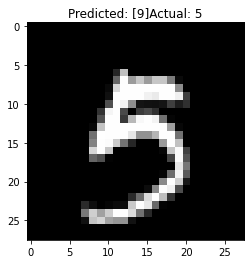

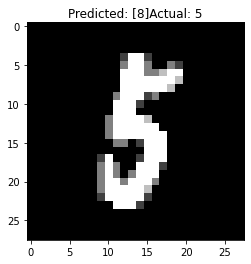

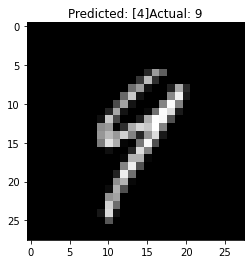

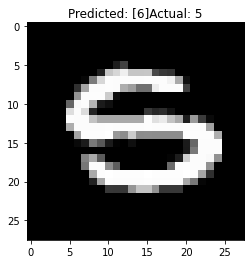

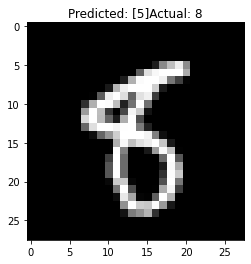

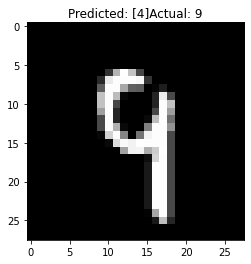

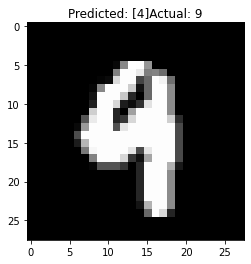

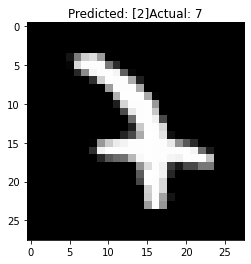

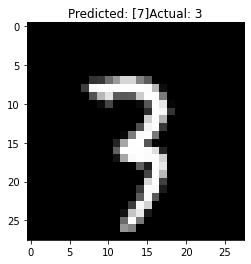

In [710]:
import matplotlib.pyplot as plt

x_test_T = x_test.T
y_test_T = y_test.T
for i in range(250, 259):
    plt.imshow(x_test_T[misclassified[0][i]].reshape(28, 28), cmap='gray')
    plt.title("Predicted: " + str(predict(x_test_T[misclassified[0][i]].reshape(784, 1), model_12)) + "Actual: " + str(np.argmax(y_test_T[misclassified[0][i]])))
    plt.show()